In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
#nj07294.ap-southeast-1

In [2]:
accountname = 'nj07294.ap-southeast-1'
#accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

In [5]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

In [7]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [8]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

# Filter

In [9]:
sdf = session.table('ANALYTICS.ORDERS_V')
df=sdf.filter(col("COUNTRY")=='United States')

In [10]:
df=sdf.filter(col("COUNTRY")=='United States')

In [11]:
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"E_MAIL"  |"PHONE_NUMBER"  |"CHILDREN_COUNT"  |"GENDER"  |"MARITAL_STATUS"  |"MENU_ITEM_ID"  |"MENU_ITEM_NAME"   

### Extracting weather data

In [99]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [100]:
wdf.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [101]:
wdf2 = wdf.to_pandas()


In [102]:
wdf2.head()

,POSTAL_CODE,COUNTRY,DATE_VALID_STD,DOY_STD,MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,MIN_TEMPERATURE_WETBULB_2M_F,AVG_TEMPERATURE_WETBULB_2M_F,MAX_TEMPERATURE_WETBULB_2M_F,...,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,MIN_CLOUD_COVER_TOT_PCT,AVG_CLOUD_COVER_TOT_PCT,MAX_CLOUD_COVER_TOT_PCT,MIN_RADIATION_SOLAR_TOTAL_WPM2,AVG_RADIATION_SOLAR_TOTAL_WPM2,MAX_RADIATION_SOLAR_TOTAL_WPM2,TOT_RADIATION_SOLAR_TOTAL_WPM2
0,71678,US,2021-06-24,175,72.0,82.7,92.8,70.0,75.4,78.4,...,0.0,0.0,0.0,0,22,85,0.0,288.4,911.3,6922.5
1,71701,US,2021-06-24,175,72.9,83.7,95.3,71.0,76.5,79.7,...,0.0,0.0,0.0,0,32,100,0.0,237.0,865.5,5686.7
2,71858,US,2021-06-24,175,73.4,83.8,93.6,72.1,76.2,78.6,...,0.0,0.0,0.0,0,23,97,0.0,274.1,874.3,6579.9
3,72085,US,2021-06-24,175,67.6,81.0,91.4,66.0,74.4,79.2,...,0.0,0.0,0.0,0,33,100,0.0,265.8,779.8,6379.2
4,72124,US,2021-06-24,175,71.8,82.7,92.3,69.2,75.3,79.2,...,0.0,0.0,0.0,0,37,100,0.0,252.4,873.3,6056.3


### Drop columns (like discount amount, etc)

In [103]:
df=df.drop(['ORDER_DISCOUNT_AMOUNT','ORDER_TAX_AMOUNT','ORDER_AMOUNT','PRICE','UNIT_PRICE','QUANTITY','MENU_ITEM_NAME','MENU_ITEM_ID','MARITAL_STATUS','GENDER','CHILDREN_COUNT','PHONE_NUMBER','E_MAIL','LAST_NAME','FIRST_NAME','CUSTOMER_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','FRANCHISE_ID','FRANCHISE_FLAG','LINE_NUMBER','ORDER_ID'])

### Transform order_ts to year, month, day, day of the week, hour, public holiday binary

In [104]:
df=df.withColumn("Month",F.month(df["ORDER_TS"]))
df=df.withColumn("DOW",F.dayofweek(df["ORDER_TS"]))
df=df.withColumn("Day",F.dayofmonth(df["ORDER_TS"]))
df=df.withColumn("Hour",F.hour(df["ORDER_TS"]))
df=df.withColumn("WOM", ((F.dayofmonth(F.col('ORDER_TS')) - 1) / 7 + 1).cast('integer'))

In [105]:
# Create public holiday column binary
public_holidays = [
    {'Month': 7, 'Day': 4, 'DOW': None, 'WOM': None},  # 4th of July
    {'Month': 12, 'Day': 24, 'DOW': None, 'WOM': None},  # Christmas Eve
    {'Month': 12, 'Day': 25, 'DOW': None, 'WOM': None},  # Christmas Day
    {'Month': 10, 'Day': None, 'DOW': '1', 'WOM': 2},  # Columbus Day (second Monday in October)
    {'Month': 6, 'Day': 19, 'DOW': None, 'WOM': None},  # Juneteenth
    {'Month': 9, 'Day': None, 'DOW': '1', 'WOM': 1},  # Labor Day (first Monday in September)
    {'Month': 1, 'Day': None, 'DOW': '1', 'WOM': 3},  # Martin Luther King, Jr. Day (third Monday in January)
    {'Month': 5, 'Day': None, 'DOW': '1', 'WOM': -1},  # Memorial Day (last Monday in May)
    {'Month': 1, 'Day': 1, 'DOW': None, 'WOM': None},  # New Year's Day
    {'Month': 12, 'Day': 31, 'DOW': None, 'WOM': None},  # New Year's Eve
    {'Month': 11, 'Day': None, 'DOW': '4', 'WOM': 4},  # Thanksgiving Day (fourth Thursday in November)
    {'Month': 11, 'Day': None, 'DOW': '3', 'WOM': 4},  # Thanksgiving Eve (fourth Wednesday in November)
    {'Month': 2, 'Day': 14, 'DOW': None, 'WOM': None},  # Valentine's Day
    {'Month': 11, 'Day': 11, 'DOW': None, 'WOM': None},  # Veterans Day
    {'Month': 10, 'Day': 31, 'DOW': None, 'WOM': None},  # Halloween
    {'Month': 3, 'Day': 17, 'DOW': None, 'WOM': None},  # St. Patrick's Day
    {'Month': 11, 'Day': 25, 'DOW': '5', 'WOM': None},  # Black Friday
    {'Month': 12, 'Day': 26, 'DOW': None, 'WOM': None},  # Boxing Day
]

In [106]:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType
'''def is_public_holiday(month, day, dow, wom):
    for holiday in public_holidays:
        if holiday['Month'] == month and holiday['DOW'] == dow and holiday['WOM'] == wom:
            if holiday['Day'] is None:
                return True
            elif holiday['Day'] == day:
                return True
    return False

session.sql("USE SCHEMA RAW_POS").collect()
@udf(session=session, name='public_holiday', input_types=[IntegerType(), IntegerType(), IntegerType(), IntegerType()], return_type=IntegerType(), is_permanent=False, replace=True)
def public_holiday(month: int, day: int, dow: int, wom: int) -> int:
    if is_public_holiday(month, day, dow, wom):
        return 1
    else:
        return 0

df=df.withColumn('PUBLIC_HOLIDAY', public_holiday(F.month(F.col('DATE')), F.dayofmonth(F.col('DATE')), F.dayofweek(F.col('DATE')), ((F.col('Day') - 1) / 7 + 1).cast('integer')))'''

from snowflake.snowpark.functions import col, when

# Initialize the 'PUBLIC_HOLIDAY' column to 0
df = df.withColumn('PUBLIC_HOLIDAY', F.lit(0))

# Iterate through the public_holidays list and update the 'PUBLIC_HOLIDAY' column
for h in public_holidays:
    df = df.withColumn(
        'PUBLIC_HOLIDAY',
        when(
            (F.month(F.col('DATE')) == h['Month']) &
            (F.dayofweek(F.col('DATE')) == h['DOW'] if h['DOW'] is not None else True) &
            (((F.col('Day') - 1) / 7 + 1).cast('integer') == h['WOM'] if h['WOM'] is not None else True) &
            (F.dayofmonth(F.col('DATE')) == h['Day'] if h['Day'] is not None else True),
            1
        ).otherwise(F.col('PUBLIC_HOLIDAY')))

## Grouping

In [107]:
df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"LOCATION_ID"  |"ORDER_TOTAL"  |"MONTH"  |"DOW"  |"DAY"  |"HOUR"  |"WOM"  |"PUBLIC_HOLIDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-05-07  |17          |2022-05-07 19:16:49  |883147729          |Smoky BBQ           |BBQ          |Denver          |Colorado  |United States  |5112           |46.0000        |5        |6      |7      |19      |2      |0                 |
|2022-05-07  |17          |2

In [108]:
grouped_df = df.groupBy("DATE","TRUCK_ID","MONTH","HOUR","DOW","DAY","Menu_Type","LOCATION_ID","PUBLIC_HOLIDAY").agg(F.sum("ORDER_TOTAL"))

# Joining with weather data

In [109]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [110]:
wdf=wea_session.sql("select * From STANDARD_TILE.HISTORY_DAY")

In [111]:
print(type(wdf))
#print(type(semi_final_df))

<class 'snowflake.snowpark.dataframe.DataFrame'>


In [112]:
grouped_df.show()

---------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"     |"LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |
---------------------------------------------------------------------------------------------------------------------------------------
|2022-05-05  |65          |5        |10      |4      |5      |Ramen           |12058          |0                 |20461.5000          |
|2022-05-05  |65          |5        |22      |4      |5      |Ramen           |3280           |0                 |12095.7500          |
|2022-05-05  |66          |5        |11      |4      |5      |Grilled Cheese  |3245           |0                 |7303.0000           |
|2022-05-05  |66          |5        |16      |4      |5      |Grilled Cheese  |2173           |0                 |8848.0000           |
|2022-05-05  |67          |5        |12      |4 

In [113]:
wdf_re=wdf.with_column_renamed(col("DATE_VALID_STD"), "DATE")

In [114]:
sdf_loc = session.table('RAW_POS.Location_New')

In [115]:
sdf_loc_dr=sdf_loc.drop("PLACEKEY","ISO_COUNTRY_CODE")

In [116]:
sdf_loc_dr.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"LOCATION"                                        |"CITY"  |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"               |"ZIPCODE"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|1030           |University Of Colorado Museum Of Natural History  |Denver  |CO        |United States  |40.00768674326263   |-105.26970066129032  |80802      |
|1031           |Denver Technological Center                       |Denver  |CO        |United States  |39.62735682905758   |-104.91269066527825  |80237      |
|1032           |Heritage Club At Denver Tech Center               |Denver  |CO        |United States  |39.62526657316754   |-104.91238594440485  |80237      |
|1033           |Porter Wound Care Cente

In [117]:
semi_final_df=grouped_df.join(sdf_loc_dr, grouped_df["LOCATION_ID"] == sdf_loc_dr["LOCATION_ID"])

In [118]:
semi_final_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"l_hiu2_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_kjds_LOCATION_ID"  |"LOCATION"                   |"CITY"         |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"              |"ZIPCODE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-02-05  |62          |2        |20      |6      |5      |BBQ           |4111                  |0                 |20145.00

In [119]:
# # # # weather=wdf_re.to_pandas()
# weather=wdf_re.to_pandas()
# syntax=pd.io.sql.get_schema(weather, "weather_data")
# session.use_schema("ANALYTICS")
# session.sql(
    
#     syntax
# ).collect()
# session.write_pandas(
#     df=weather,
#     table_name="weather_data",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [120]:
semi_final_df=semi_final_df.with_column_renamed(col("ZIPCODE"), "POSTAL_CODE")

In [121]:
type(wdf_re["DATE"])

snowflake.snowpark.column.Column

In [122]:
wdf = session.table('RAW_POS.weather_data')
wdf=wdf.select("POSTAL_CODE","DATE","COUNTRY","AVG_TEMPERATURE_AIR_2M_F","AVG_TEMPERATURE_HEATINDEX_2M_F","TOT_PRECIPITATION_IN","TOT_SNOWFALL_IN","TOT_SNOWDEPTH_IN","AVG_CLOUD_COVER_TOT_PCT")


In [123]:
final_df = semi_final_df.join(wdf, (semi_final_df["DATE"] == wdf["DATE"]) & (semi_final_df["POSTAL_CODE"] == wdf["POSTAL_CODE"])  )

In [124]:
session.use_schema("ANALYTICS")
final_df.write.save_as_table(table_name="sales_prediction", mode='overwrite')

## Merging

In [140]:
to_encode_df = session.table('ANALYTICS.SALES_PREDICTION')

In [141]:
to_encode_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_xsyi_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"l_8e63_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_mzda_LOCATION_ID"  |"LOCATION"          |"CITY"         |"REGION"  |"l_xsyi_COUNTRY"  |"LAT"              |"LONG"               |"l_xsyi_POSTAL_CODE"  |"r_rc5d_POSTAL_CODE"  |"r_rc5d_DATE"  |"r_rc5d_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"

In [211]:
columns_to_drop = ['"r_mzda_LOCATION_ID"','"l_xsyi_COUNTRY"','"l_xsyi_POSTAL_CODE"','"r_rc5d_POSTAL_CODE"','"r_ykpq_COUNTRY"','"r_rc5d_DATE"']
new_columns  = [c for c in to_encode_df.columns if c not in columns_to_drop]
dropped_df = to_encode_df.select(*new_columns)

In [212]:
dropped_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_xsyi_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"l_8e63_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"         |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"r_rc5d_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [173]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTE",

    "warehouse": "HOL_WH"
}

nt_session = Session.builder.configs(connection_parameters).create()
sales = nt_session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_Base")

In [174]:
sales.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [178]:
import decimal 


In [180]:
decimal.getcontext().prec=2

In [182]:
sales=sales.na.fill({'DAY_OF_WEEK_AVG_CITY_MENU_TYPE': decimal.Decimal(1683.14), 'PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE': decimal.Decimal(292095.22)})

In [183]:
sales.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [206]:
merge_df=nt_session.sql("""SELECT
DATE,
  LOCATION_ID,
  MENU_TYPE,
  SUM(DAY_OF_WEEK_AVG_CITY_MENU_TYPE) AS SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,
  SUM(PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE) AS SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
FROM ANALYTICS.DEMAND_FORECAST_TRAINING_Base
GROUP BY DATE, LOCATION_ID, MENU_TYPE""")

In [207]:
mdf=merge_df.to_pandas()

In [208]:
# syntax=pd.io.sql.get_schema(mdf, "DEMAND_FORECAST_TRAINING_Base")
# session.use_schema("ANALYTICS")
# session.sql(

#     syntax
# ).collect()
# session.write_pandas(
#     df=mdf,
#     table_name="DEMAND_FORECAST_TRAINING_Base",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [213]:
mdf=session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_BASE")

In [216]:
mdf.show()

--------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------------------------------------------------------------
|2022-07-27  |12599          |Ice Cream    |1.2E+4                                |NULL                                        |
|2020-07-02  |2935           |Sandwiches   |4.1E+3                                |NULL                                        |
|2022-01-05  |15485          |Ramen        |8.9E+3                                |1.6E+6                                      |
|2022-02-26  |3821           |Gyros        |2.9E+4                                |NULL                                        |
|2021-09-25  |3722           |Crepes       |2.9E+4                                |NULL          

In [217]:
mdf.where(col("SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE").isNull()).count()

283962

In [218]:
mdf.count()

510890

In [66]:
mdf.show()

---------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"     |"DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
---------------------------------------------------------------------------------------------------------------------------
|2022-05-13  |11737          |Tacos           |3016.26073                        |NULL                                    |
|2021-12-24  |5860           |Mac & Cheese    |3340.08737                        |NULL                                    |
|2021-07-31  |6188           |Sandwiches      |4352.92                           |NULL                                    |
|2022-09-09  |11318          |Mac & Cheese    |4482.81034                        |NULL                                    |
|2022-08-13  |14352          |BBQ             |3523.28049                        |974977.0                                |
|2022-09

In [220]:
dropped_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_xsyi_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"l_8e63_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"         |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"r_rc5d_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [221]:
merge_df=dropped_df.join(mdf, (dropped_df['"l_xsyi_DATE"'] == mdf["DATE"])& (dropped_df['"MENU_TYPE"'] == mdf["MENU_TYPE"])& (dropped_df['"l_8e63_LOCATION_ID"'] == mdf["Location_ID"])).drop('"l_xsyi_DATE"').drop('"Date"').drop('"l_8e63_LOCATION_ID"')

In [222]:
merge_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"l_4h4w_MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"             |"CITY"   |"REGION"  |"LAT"               |"LONG"               |"r_rc5d_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"r_h7y8_MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES

In [224]:
merge_df = merge_df.withColumnRenamed('"l_4h4w_MENU_TYPE"','Menu_Type')

In [225]:
merge_df=merge_df.drop('"r_h7y8_MENU_TYPE"').drop('"r_rc5d_COUNTRY"')

In [226]:
merge_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"             |"CITY"   |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------

## Null Encoding

In [227]:
nullColumns = []
numRows = merge_df.count()
for k in merge_df.columns:
    
    nullRows = merge_df.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(merge_df.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['AVG_TEMPERATURE_AIR_2M_F', 0],
 ['AVG_TEMPERATURE_HEATINDEX_2M_F', 0],
 ['TOT_PRECIPITATION_IN', 0],
 ['TOT_SNOWFALL_IN', 0],
 ['TOT_SNOWDEPTH_IN', 0],
 ['AVG_CLOUD_COVER_TOT_PCT', 0],
 ['DATE', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 1684, [2172863.25]]]

In [230]:
dropped_df=merge_df.na.fill({'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE': decimal.Decimal(1683.1472034615383), 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE':decimal.Decimal(292095.2258064516)})

In [231]:
nullColumns = []
numRows = dropped_df.count()
for k in dropped_df.columns:
    
    nullRows = dropped_df.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(dropped_df.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['AVG_TEMPERATURE_AIR_2M_F', 0],
 ['AVG_TEMPERATURE_HEATINDEX_2M_F', 0],
 ['TOT_PRECIPITATION_IN', 0],
 ['TOT_SNOWFALL_IN', 0],
 ['TOT_SNOWDEPTH_IN', 0],
 ['AVG_CLOUD_COVER_TOT_PCT', 0],
 ['DATE', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 0]]

In [232]:
merge_df.count()

3529

In [234]:
dropped_df=dropped_df.drop("DATE")


### Encoding

In [233]:


dropped_df.show()

columns = dropped_df.columns

# Iterate over the columns and count the number of unique values
unique_counts = {}
for column in columns:
    unique_counts[column] = dropped_df.select(column).distinct().count()

# Print the unique counts for each column
for column, count in unique_counts.items():
    print(f"Column '{column}': {count}")

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"             |"CITY"   |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------

In [235]:
categoricalColumns = ['MENU_TYPE', 'LOCATION', 'CITY', 'REGION']

In [236]:
def one_hot_encode_columns(df, column_names):
    encoded_df = df
    
    for column_name in column_names:
        unique_values = [row[column_name] for row in df.select(column_name).distinct().collect()]
        
        # Create a new column for each unique value and perform one-hot encoding
        for value in unique_values:
            encoded_column_name = f"{column_name}_{value}_encoded"
            encoded_df = encoded_df.withColumn(encoded_column_name, F.when(F.col(column_name) == value, 1).otherwise(0))
    
    
    return encoded_df

In [237]:
encoded_df = one_hot_encode_columns(dropped_df, categoricalColumns)

In [238]:
final_df = encoded_df.drop(*categoricalColumns)

In [239]:
final_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [241]:
final_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [242]:
X_final=final_df

In [243]:
session.use_schema("ANALYTICS")
X_final.write.save_as_table(table_name="Encoded_Data", mode='overwrite')

In [244]:
X_final=X_final.to_pandas()

In [245]:
columns_not_to_scale=["TRUCK_ID","MONTH","HOUR","DOW","DAY","PUBLIC_HOLIDAY","LOCATION_ID","LAT","LONG","SUM(ORDER_TOTAL)"]     

cat_col = [i for i in X_final.columns if i not in columns_not_to_scale]




In [246]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
scaler=StandardScaler()
scaler.fit(X_final)
X_final_scaled = X_final.copy()
X_final_scaled[cat_col] = StandardScaler().fit_transform(X_final_scaled[cat_col])

In [247]:

y_final=final_df[['SUM(ORDER_TOTAL)']]
y_final=y_final.to_pandas()
y_final=pd.DataFrame(y_final,columns=y_final.columns)

In [248]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,SUM(ORDER_TOTAL),LAT,LONG,AVG_TEMPERATURE_AIR_2M_F,...,LOCATION_Speer Blvd Park_encoded,LOCATION_Emeritus at West Seattle_encoded,LOCATION_Ball arena formerly Pepsi Center_encoded,LOCATION_A Caring Hand_encoded,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_New York City_encoded,REGION_CO_ENCODED,REGION_NY_ENCODED,REGION_WA_ENCODED
0,29,8,9,1,16,0,4713.0,39.750623,-105.005176,1.261007,...,3.995791,-0.239207,-0.296968,-0.261577,-0.789005,1.908775,-0.818136,1.908775,-0.818136,-0.789005
1,29,8,8,1,16,0,2907.0,39.750623,-105.005176,1.261007,...,3.995791,-0.239207,-0.296968,-0.261577,-0.789005,1.908775,-0.818136,1.908775,-0.818136,-0.789005
2,29,8,12,1,16,0,4976.0,39.750623,-105.005176,1.261007,...,3.995791,-0.239207,-0.296968,-0.261577,-0.789005,1.908775,-0.818136,1.908775,-0.818136,-0.789005
3,29,8,10,1,16,0,4373.0,39.750623,-105.005176,1.261007,...,3.995791,-0.239207,-0.296968,-0.261577,-0.789005,1.908775,-0.818136,1.908775,-0.818136,-0.789005
4,29,8,11,1,16,0,3422.0,39.750623,-105.005176,1.261007,...,3.995791,-0.239207,-0.296968,-0.261577,-0.789005,1.908775,-0.818136,1.908775,-0.818136,-0.789005


In [164]:
import math

In [249]:
X_final_scaled.rename(columns={"SUM(ORDER_TOTAL)": "Profit"},inplace=True)

In [253]:
session.write_pandas(
    df=X_final_scaled,
    table_name="Sales_Forecast_Training_Data",
    database="FROSTBYTE_TASTY_BYTES",
    schema="ANALYTICS",
    quote_identifiers=True,
    overwrite=True
)


## Machine Learning Modelling

In [12]:
session.use_schema("ANALYTICS")
X_final_scaled=session.table("Sales_Forecast_Training_Data")

In [13]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql("Select * from Sales_Forecast_Training_Data").to_pandas()

In [13]:
X_final_scaled

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,PROFIT,LOCATION_ID,LAT,LONG,AVG_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_HEATINDEX_2M_F,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,AVG_CLOUD_COVER_TOT_PCT,DAY_OF_WEEK_AVG_CITY_MENU_TYPE,PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
0,33,12,15,5,24,1,1596.0,2290,47.561638,-122.376698,-1.370498,-1.352155,1.17069,-0.111192,-0.199874,1.302848,-0.841069,-0.593733
1,33,12,21,5,24,1,9365.5,2290,47.561638,-122.376698,-1.370498,-1.352155,1.17069,-0.111192,-0.199874,1.302848,-0.841069,-0.593733
2,33,12,19,5,24,1,4939.0,2290,47.561638,-122.376698,-1.370498,-1.352155,1.17069,-0.111192,-0.199874,1.302848,-0.841069,-0.593733
3,33,12,16,5,24,1,1017.0,2290,47.561638,-122.376698,-1.370498,-1.352155,1.17069,-0.111192,-0.199874,1.302848,-0.841069,-0.593733
4,33,12,17,5,24,1,3433.0,2290,47.561638,-122.376698,-1.370498,-1.352155,1.17069,-0.111192,-0.199874,1.302848,-0.841069,-0.593733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23561,37,2,13,0,6,0,2399.0,2290,47.561638,-122.376698,-1.154850,-1.142405,-0.43925,-0.111192,-0.199874,0.675549,-0.786248,-0.384552
23562,37,2,9,0,6,0,6356.0,2290,47.561638,-122.376698,-1.154850,-1.142405,-0.43925,-0.111192,-0.199874,0.675549,-0.786248,-0.384552
23563,37,2,10,0,6,0,3073.0,2290,47.561638,-122.376698,-1.154850,-1.142405,-0.43925,-0.111192,-0.199874,0.675549,-0.786248,-0.384552
23564,37,2,12,0,6,0,6043.0,2290,47.561638,-122.376698,-1.154850,-1.142405,-0.43925,-0.111192,-0.199874,0.675549,-0.786248,-0.384552


In [171]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23566 entries, 0 to 23565
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TRUCK_ID                              23566 non-null  int8   
 1   MONTH                                 23566 non-null  int8   
 2   HOUR                                  23566 non-null  int8   
 3   DOW                                   23566 non-null  int8   
 4   DAY                                   23566 non-null  int8   
 5   PUBLIC_HOLIDAY                        23566 non-null  int8   
 6   PROFIT                                23566 non-null  float64
 7   LOCATION_ID                           23566 non-null  int16  
 8   LAT                                   23566 non-null  float64
 9   LONG                                  23566 non-null  float64
 10  AVG_TEMPERATURE_AIR_2M_F              23566 non-null  float64
 11  AVG_TEMPERATURE

In [405]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("PROFIT",axis=1)
y = X_final_scaled["PROFIT"]

# Split the dataset into training and testing datasets
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_holdout_test, y_holdout_test, test_size=0.2, random_state=42)

In [173]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [178]:
print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

Train MSE is:  2014136.3855472703
Test MSE is:  2289623.987367086

Train RMSE is:  1419.2027288401296
Test RMSE is:  1513.150351870919

Train MAE is:  1063.968459036136
Test MAE is:  1105.815378228909

Train R2 is:  0.9527253423956941
Test R2 is:  0.9448532150166624


In [17]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

c:\Users\vibu\anaconda\envs\pysnowpark\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [18]:
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  771526.7620708488
Test MSE is:  1236772.561729723

Train RMSE is:  878.3659613571377
Test RMSE is:  1112.102765813359

Train MAE is:  641.8070704684887
Test MAE is:  777.6534032164298

Train R2 is:  0.9827021720783029
Test R2 is:  0.9715130780191024


## Fine-tuned XGBoost

In [37]:
X_holdout

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LOCATION_ID,LAT,LONG,AVG_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_HEATINDEX_2M_F,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,AVG_CLOUD_COVER_TOT_PCT,DAY_OF_WEEK_AVG_CITY_MENU_TYPE,PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
6619,43,8,19,3,25,0,5176,47.573410,-122.375880,0.368597,0.352909,-0.439250,-0.111192,-0.199874,-0.017783,0.066494,-0.384552
1310,29,8,21,5,12,0,14950,39.750623,-105.005176,1.509443,1.455787,-0.439250,-0.111192,-0.199874,-1.503493,-0.185571,0.011312
1959,40,4,11,1,25,0,15104,47.538454,-122.381150,-0.466169,-0.472559,0.063856,-0.111192,-0.199874,1.236817,-0.946665,-0.798965
9060,62,8,16,4,18,0,2980,40.779507,-73.953235,1.196406,1.164844,-0.439250,-0.111192,-0.199874,-1.437461,0.696751,2.399583
11313,44,10,14,5,22,0,3003,47.566247,-122.368663,-0.403562,-0.411664,0.063856,-0.111192,-0.199874,1.170785,0.458120,-0.384552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,35,3,18,4,24,0,3003,47.566247,-122.368663,-0.876595,-0.871760,-0.439250,-0.111192,-0.199874,0.807612,-0.267216,-0.384552
16097,40,4,9,1,25,0,15104,47.538454,-122.381150,-0.466169,-0.472559,0.063856,-0.111192,-0.199874,1.236817,-0.948127,-0.798965
2684,72,7,20,6,9,0,2129,40.782657,-73.948461,1.286839,1.273102,-0.439250,-0.111192,-0.199874,0.675549,2.019165,-0.384552
20895,40,7,20,4,1,0,15088,47.588769,-122.380905,0.695546,0.664150,-0.439250,-0.111192,-0.199874,0.543485,-0.708607,-0.384552


In [ ]:
xgb = XGBRegressor(learning_rate= 0.04, max_depth= 10, n_estimators= 1700, subsample= 0.9)
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

In [20]:
from sklearn. ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(n_estimators=40)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=40)

In [21]:

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  78348.10199978507
Test MSE is:  437040.17317599256

Train RMSE is:  279.90730965765266
Test RMSE is:  661.0901399778949

Train MAE is:  132.98237720135796
Test MAE is:  328.2591728525981

Train R2 is:  0.9982914288807593
Test R2 is:  0.9901451573523425


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import scipy.stats as stats

In [24]:
def cvr2(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training R^2 value is: ', sum(results['train_score'])/len(results['train_score']))
    print('cross val testing R^2 value is: ', sum(results['test_score'])/len(results['test_score']))

def cvrm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training rmse is:', -(sum(results['train_score'])/len(results['train_score'])))
    print('cross val testing rmse is:', -(sum(results['test_score'])/len(results['test_score'])))
    
def cvm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training mae is:', (-(sum(results['train_score'])/len(results['train_score']))))
    print('cross val testing mae is:', (-(sum(results['test_score'])/len(results['test_score']))))
    
def cv(model):
    print("R^2 value: ")
    cvr2(model)
    print(" \nRmse: ")
    cvrm(model)
    print(" \nMae: ")
    cvm(model)

In [25]:
rf = RandomForestRegressor()

param_grid = {"n_estimators"      : [10,30,50, 100, 200],
              'ccp_alpha': [0.0, 0.1, 0.2],
              'criterion': ['mse', 'absolute_error'],
#             "max_features"      : ["auto", "sqrt", "log2"],
#              "min_samples_leaf" : [1, 5, 10],
#             "min_samples_split" : [2, 4, 10, 12, 16], 
#              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
              'max_depth' : [5, 25, 125, 525, 1225]
             }

gs = GridSearchCV(rf, param_grid=param_grid, scoring='r2', cv= 3, n_jobs=-1, verbose = 2)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [ ]:
rf = RandomForestRegressor(ccp_alpha = 0.0, criterion='mse',max_depth = 525, n_estimators = 200)
rf.fit(X_train, y_train)

cv(rf)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = param_grid, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=8, n_estimators=1500,
                          subsample=0.9)

 The best score across ALL searched params:
 0.9749017238306279

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.9}


In [16]:
gbr = GradientBoostingRegressor(learning_rate= 0.04, max_depth= 8, n_estimators= 1500, subsample= 0.9)
gbr = gbr.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(gbr.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(gbr.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(gbr.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(gbr.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(gbr.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(gbr.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(gbr.predict(X_train), y_train))
print('Test R2 is: ', r2_score(gbr.predict(X_test), y_test))

Train MSE is:  3857.2668986809076
Test MSE is:  160037.05054998022

Train RMSE is:  62.10689896203889
Test RMSE is:  400.0463105066465

Train MAE is:  45.05993768646041
Test MAE is:  189.97315879533045

Train R2 is:  0.9999167569609541
Test R2 is:  0.9964613325270291


In [ ]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde = True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')


In [130]:
ab=AdaBoostRegressor(n_estimators=20,learning_rate=1)
ab.fit(X_train,y_train)
train_mse = mean_squared_error(ab.predict(X_train), y_train)#training mse
print('the training mean squared error is: ', train_mse) 
train_R2 = ab.score(X_train, y_train) #training r2
print('training R^2 value is: ', train_R2)

test_mse = mean_squared_error(ab.predict(X_test), y_test) #testing mse
print('the testing mean squared error is: ',test_mse)
test_R2 = ab.score(X_test, y_test) #testing r2
print('testing R^2 value is: ', test_R2)

the training mean squared error is:  8991744.007605808
training R^2 value is:  0.8063579674313232
the testing mean squared error is:  8906276.683779892
testing R^2 value is:  0.8056561654192178


In [132]:
from sklearn.model_selection import GridSearchCV
ab=AdaBoostRegressor(n_estimators=20,learning_rate=1)
param_grid = {"n_estimators":[10,50,100,300], "loss" : ['linear', 'square','exponential'], "learning_rate" : [0.5,1,2,3]}
gs = GridSearchCV(ab, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) # 

print(gs.best_score_)
print(gs.best_params_)

c:\Users\kohja\.conda\envs\snowpark_0110\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


nan
{'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 10}


## Routing Build

In [407]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(ccp_alpha = 0.0, criterion='mse',max_depth = 525, n_estimators = 200)
rf.fit(X_train, y_train)

holdout_predictions = rf.predict(X_holdout)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_holdout, holdout_predictions)

# Print the MSE
print(f"Mean Squared Error (MSE) on holdout data: {mse}")


c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean Squared Error (MSE) on holdout data: 477658.7676799125


In [408]:
X_holdout

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LOCATION_ID,LAT,LONG,AVG_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_HEATINDEX_2M_F,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,AVG_CLOUD_COVER_TOT_PCT,DAY_OF_WEEK_AVG_CITY_MENU_TYPE,PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
6619,43,8,19,3,25,0,5176,47.573410,-122.375880,0.368597,0.352909,-0.439250,-0.111192,-0.199874,-0.017783,0.066494,-0.384552
1310,29,8,21,5,12,0,14950,39.750623,-105.005176,1.509443,1.455787,-0.439250,-0.111192,-0.199874,-1.503493,-0.185571,0.011312
1959,40,4,11,1,25,0,15104,47.538454,-122.381150,-0.466169,-0.472559,0.063856,-0.111192,-0.199874,1.236817,-0.946665,-0.798965
9060,62,8,16,4,18,0,2980,40.779507,-73.953235,1.196406,1.164844,-0.439250,-0.111192,-0.199874,-1.437461,0.696751,2.399583
11313,44,10,14,5,22,0,3003,47.566247,-122.368663,-0.403562,-0.411664,0.063856,-0.111192,-0.199874,1.170785,0.458120,-0.384552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,35,3,18,4,24,0,3003,47.566247,-122.368663,-0.876595,-0.871760,-0.439250,-0.111192,-0.199874,0.807612,-0.267216,-0.384552
16097,40,4,9,1,25,0,15104,47.538454,-122.381150,-0.466169,-0.472559,0.063856,-0.111192,-0.199874,1.236817,-0.948127,-0.798965
2684,72,7,20,6,9,0,2129,40.782657,-73.948461,1.286839,1.273102,-0.439250,-0.111192,-0.199874,0.675549,2.019165,-0.384552
20895,40,7,20,4,1,0,15088,47.588769,-122.380905,0.695546,0.664150,-0.439250,-0.111192,-0.199874,0.543485,-0.708607,-0.384552


In [409]:
X_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7541 entries, 6619 to 884
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TRUCK_ID                              7541 non-null   int8   
 1   MONTH                                 7541 non-null   int8   
 2   HOUR                                  7541 non-null   int8   
 3   DOW                                   7541 non-null   int8   
 4   DAY                                   7541 non-null   int8   
 5   PUBLIC_HOLIDAY                        7541 non-null   int8   
 6   LOCATION_ID                           7541 non-null   int16  
 7   LAT                                   7541 non-null   float64
 8   LONG                                  7541 non-null   float64
 9   AVG_TEMPERATURE_AIR_2M_F              7541 non-null   float64
 10  AVG_TEMPERATURE_HEATINDEX_2M_F        7541 non-null   float64
 11  TOT_PRECIPITATI

In [410]:
X_holdout.describe()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LOCATION_ID,LAT,LONG,AVG_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_HEATINDEX_2M_F,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,AVG_CLOUD_COVER_TOT_PCT,DAY_OF_WEEK_AVG_CITY_MENU_TYPE,PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
count,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000
mean,46.612783,6.789020,14.715290,3.100517,14.810237,0.030367,5788.341467,43.146947,-99.022444,0.005813,0.006226,-0.005402,-0.006269,0.000396,0.011814,0.010211,0.016032
std,18.791976,3.009651,4.215824,1.975641,8.882802,0.171607,5058.566969,3.498545,21.712395,0.995858,0.997082,0.988643,0.945178,0.985196,0.987851,0.999838,1.010585
min,16.000000,1.000000,8.000000,0.000000,1.000000,0.000000,1280.000000,39.748191,-122.381150,-3.123506,-3.057219,-0.439250,-0.111192,-0.199874,-1.932698,-1.207228,-1.142941
25%,31.000000,5.000000,11.000000,1.000000,7.000000,0.000000,2762.000000,40.547625,-122.375880,-0.765293,-0.763502,-0.439250,-0.111192,-0.199874,-0.843177,-0.793686,-0.416381
50%,41.000000,7.000000,15.000000,3.000000,15.000000,0.000000,3353.000000,40.783667,-105.009729,0.104254,0.082264,-0.439250,-0.111192,-0.199874,0.180312,-0.459812,-0.384552
75%,67.000000,9.000000,18.000000,5.000000,22.000000,0.000000,5176.000000,47.561638,-73.953235,0.785979,0.765642,-0.187697,-0.111192,-0.199874,0.906659,0.811440,-0.284271
max,75.000000,12.000000,22.000000,6.000000,31.000000,1.000000,15188.000000,47.588769,-73.948461,2.100735,2.260956,7.509826,17.009380,9.874649,1.368880,5.203639,3.663168


In [411]:
# Get the columns to exclude
columns_to_exclude = ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.drop(columns=columns_to_exclude)
df_predictions['Holdout'] = y_holdout
holdout_predictions = rf.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)



       TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY  LOCATION_ID  \
6619         43      8    19    3   25               0         5176   
1310         29      8    21    5   12               0        14950   
1959         40      4    11    1   25               0        15104   
9060         62      8    16    4   18               0         2980   
11313        44     10    14    5   22               0         3003   
...         ...    ...   ...  ...  ...             ...          ...   
13220        35      3    18    4   24               0         3003   
16097        40      4     9    1   25               0        15104   
2684         72      7    20    6    9               0         2129   
20895        40      7    20    4    1               0        15088   
884          17      6    15    0   19               1         5133   

             LAT        LONG  DAY_OF_WEEK_AVG_CITY_MENU_TYPE  \
6619   47.573410 -122.375880                        0.066494   
1310   39.750623 -1

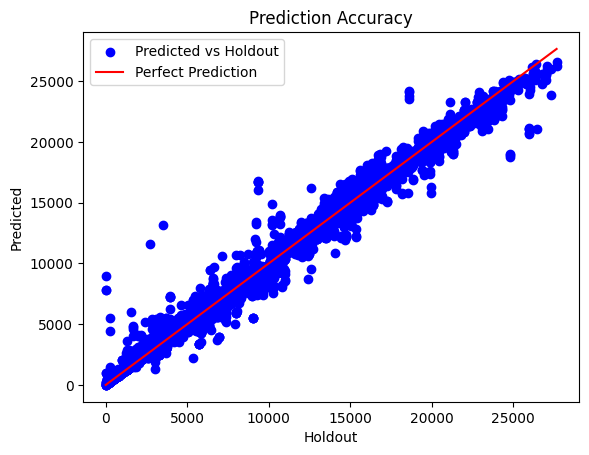

In [412]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [413]:
from tabulate import tabulate

# Prompt the user for input
# truck_id = int(input("Enter the Truck ID: "))
# month = int(input("Enter the Month: "))
# day = int(input("Enter the Day: "))

# INPUT VALIDATION
# Prompt the user for input and perform input validation
'''
while True:
    try:
        truck_id = int(input("Enter the Truck ID (between 16 and 75): "))
        if not (16 <= truck_id <= 75):
            raise ValueError("Truck ID must be between 16 and 75")
        
        month = int(input("Enter the Month (1-12): "))
        if not (1 <= month <= 12):
            raise ValueError("Month must be between 1 and 12")
        
        if month in [1, 3, 5, 7, 8, 10, 12]:
            day_limit = 31
        elif month in [4, 6, 9, 11]:
            day_limit = 30
        elif month == 2:
            day_limit = 28
        else:
            raise ValueError("Invalid month")
        
        day = int(input(f"Enter the Day (1-{day_limit}): "))
        if not (1 <= day <= day_limit):
            raise ValueError(f"Day must be between 1 and {day_limit}")
        
        break
    
    except ValueError as e:
        print("Invalid input:", e)
'''

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Get the holdout values, predicted values, and best location ID for the current hour
    holdout_values = hour_df['Holdout'].tolist()
    predicted_values = hour_df['Predicted'].tolist()
    best_location_id = hour_df['LOCATION_ID'].iloc[0]
    possible_location_ids = hour_df['LOCATION_ID'].unique().tolist()

    # Append the row to the table_rows list
    table_rows.append([hour, best_location_id, possible_location_ids, holdout_values, predicted_values])

# Create a DataFrame from the table_rows list
df_best_loc_id = pd.DataFrame(table_rows, columns=["Hour", "Best Location ID", "Possible Location IDs", "Holdout Values", "Predicted Values"])



In [414]:
import pyfiglet
from termcolor import colored

# Create a Figlet object for ASCII art text
figlet = pyfiglet.Figlet(font='ogre')


# Convert the truck ID, month, and day to string
truck_id_str = str(truck_id)
month_str = str(month)
day_str = str(day)

# Concatenate the ASCII art and numbers in one row
art_row = ' '.join([
    figlet.renderText("Truck ID: " + truck_id_str + " Month: " + month_str + " Day: " + day_str)
])

# Print the ASCII art row
print(art_row)

# Print the DataFrame
df_best_loc_id


 _____                 _       _____  ___     _  _  _____ 
/__   \_ __ _   _  ___| | __   \_   \/   \_  | || ||___ / 
  / /\/ '__| | | |/ __| |/ /    / /\/ /\ (_) | || |_ |_ \ 
 / /  | |  | |_| | (__|   <  /\/ /_/ /_// _  |__   _|__) |
 \/   |_|   \__,_|\___|_|\_\ \____/___,' (_)    |_||____/ 
                                                          
                    _   _          ___       ___                ____  ____  
  /\/\   ___  _ __ | |_| |__  _   ( _ )     /   \__ _ _   _ _  |___ \| ___| 
 /    \ / _ \| '_ \| __| '_ \(_)  / _ \    / /\ / _` | | | (_)   __) |___ \ 
/ /\/\ \ (_) | | | | |_| | | |_  | (_) |  / /_// (_| | |_| |_   / __/ ___) |
\/    \/\___/|_| |_|\__|_| |_(_)  \___/  /___,' \__,_|\__, (_) |_____|____/ 
                                                      |___/                 



,Hour,Best Location ID,Possible Location IDs,Holdout Values,Predicted Values
0,15,5176,[5176],"[3594.0, 3594.0, 3594.0, 3594.0, 3594.0]","[3422.42, 3230.5125, 3165.8075, 3147.1225, 314..."
1,16,5176,[5176],"[3566.0, 3566.0]","[3755.78125, 3475.4925]"
2,17,5176,[5176],[6274.0],[7288.91]
3,19,5176,[5176],"[10344.0, 10344.0]","[8132.29, 8093.24]"
4,20,5176,[5176],"[9248.0, 9248.0, 9248.0]","[10551.315, 10538.6725, 10523.6]"
5,21,5176,[5176],[7990.0],[7909.5075]


In [415]:
filtered_df

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LOCATION_ID,LAT,LONG,DAY_OF_WEEK_AVG_CITY_MENU_TYPE,PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE,Holdout,Predicted,Difference
6619,43,8,19,3,25,0,5176,47.57341,-122.37588,0.066494,-0.384552,10344.0,8132.29000,-2211.71000
6108,43,8,15,3,25,0,5176,47.57341,-122.37588,0.012310,-0.384552,3594.0,3147.12250,-446.87750
19415,43,8,17,3,25,0,5176,47.57341,-122.37588,0.069872,-0.384552,6274.0,7288.91000,1014.91000
11897,43,8,20,3,25,0,5176,47.57341,-122.37588,-0.016024,-0.384552,9248.0,10538.67250,1290.67250
18281,43,8,16,3,25,0,5176,47.57341,-122.37588,0.039926,-0.384552,3566.0,3755.78125,189.78125
11895,43,8,21,3,25,0,5176,47.57341,-122.37588,-0.016024,-0.384552,7990.0,7909.50750,-80.49250
11892,43,8,15,3,25,0,5176,47.57341,-122.37588,-0.016024,-0.384552,3594.0,3143.61250,-450.38750
11092,43,8,15,3,25,0,5176,47.57341,-122.37588,-0.041927,-0.384552,3594.0,3165.80750,-428.19250
6113,43,8,20,3,25,0,5176,47.57341,-122.37588,0.012310,-0.384552,9248.0,10523.60000,1275.60000
18280,43,8,15,3,25,0,5176,47.57341,-122.37588,0.039926,-0.384552,3594.0,3230.51250,-363.48750


In [416]:
# Get unique location IDs
unique_location_ids = df_predictions['LOCATION_ID'].unique()
print("Unique Location IDs:", unique_location_ids)

# Create a list to store the table data
table_data = []


# Create a DataFrame to store the table data
df_unique_locations_lat_long = pd.DataFrame(columns=["Location ID", "Latitude", "Longitude"])

# Iterate over each unique location ID
for location_id in unique_location_ids:
    location = df_predictions[df_predictions['LOCATION_ID'] == location_id]
    latitude = location['LAT'].values[0]
    longitude = location['LONG'].values[0]
    df_unique_locations_lat_long = pd.concat([df_unique_locations_lat_long, pd.DataFrame({"Location ID": [location_id],
                                                  "Latitude": [latitude],
                                                  "Longitude": [longitude]})],
                         ignore_index=True)

    

# Print the DataFrame
df_unique_locations_lat_long


Unique Location IDs: [ 5176 14950 15104  2980  3003  5133  2762  2272  2290  3606  1280  3353
  2867 15088  2129 15188]


,Location ID,Latitude,Longitude
0,5176,47.573410,-122.375880
1,14950,39.750623,-105.005176
2,15104,47.538454,-122.381150
3,2980,40.779507,-73.953235
4,3003,47.566247,-122.368663
5,5133,39.752366,-105.010343
6,2762,47.581608,-122.373686
7,2272,47.561638,-122.376698
8,2290,47.561638,-122.376698
9,3606,39.748191,-105.009729


### CONVERT TO FUNCTION

In [417]:
import math
import pandas as pd

def calculate_distances(df_predictions, starting_location_id):
    def haversine_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance

    # Find the reference location based on the starting location ID
    reference_location = df_predictions[df_predictions['LOCATION_ID'] == starting_location_id]
    reference_latitude = reference_location['LAT'].values[0]
    reference_longitude = reference_location['LONG'].values[0]

    # List of other locations with their respective location IDs, latitudes, and longitudes
    other_locations = df_predictions[['LOCATION_ID', 'LAT', 'LONG']].drop_duplicates().values.tolist()

    # Calculate distances between starting location and other locations
    distances = []
    for location in other_locations:
        location_id = location[0]
        latitude = location[1]
        longitude = location[2]
        distance = haversine_distance(reference_latitude, reference_longitude, latitude, longitude)
        distances.append({'Location_ID_start': starting_location_id, 'Location_ID_end': location_id, 'distance': distance})

    # Create a DataFrame from the distances list
    df_distances = pd.DataFrame(distances)

    # Sort the DataFrame by distance in ascending order
    df_distances = df_distances.sort_values('distance')

    return df_distances

# Example usage
reference_location_id = 5176
df_distances = calculate_distances(df_predictions, reference_location_id)
print(f"Distances from Location ID {reference_location_id}:")
df_distances


Distances from Location ID 5176:


,Location_ID_start,Location_ID_end,distance
0,5176,5176.0,0.000000
6,5176,2762.0,0.926345
4,5176,3003.0,0.963089
7,5176,2272.0,1.310495
8,5176,2290.0,1.310495
13,5176,15088.0,1.748887
2,5176,15104.0,3.907046
5,5176,5133.0,1639.857835
9,5176,3606.0,1640.183464
1,5176,14950.0,1640.325863


In [418]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate= 0.04, max_depth= 10, n_estimators= 1700, subsample= 0.9)
xgb.fit(X_train, y_train)

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)


c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


       TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY  LOCATION_ID  \
6619         43      8    19    3   25               0         5176   
1310         29      8    21    5   12               0        14950   
1959         40      4    11    1   25               0        15104   
9060         62      8    16    4   18               0         2980   
11313        44     10    14    5   22               0         3003   
...         ...    ...   ...  ...  ...             ...          ...   
13220        35      3    18    4   24               0         3003   
16097        40      4     9    1   25               0        15104   
2684         72      7    20    6    9               0         2129   
20895        40      7    20    4    1               0        15088   
884          17      6    15    0   19               1         5133   

             LAT        LONG  AVG_TEMPERATURE_AIR_2M_F  \
6619   47.573410 -122.375880                  0.368597   
1310   39.750623 -105.005176   

In [419]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

columns_to_exclude = ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = rf.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Get the holdout values, predicted values, and best location ID for the current hour
    holdout_values = hour_df['Holdout'].tolist()
    predicted_values = hour_df['Predicted'].tolist()
    best_location_id = hour_df['LOCATION_ID'].iloc[0]

    # Filter distances DataFrame for distances less than 4 km from location_id 5176.0
    filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

    # Get the possible location IDs including the newly added location IDs
    possible_location_ids = sorted(set(hour_df['LOCATION_ID'].unique()) | set(filtered_distances['Location_ID_end'].unique()))

    # Initialize a list to hold the predicted values for each possible location ID
    predicted_values_per_location = []

    # Loop through each possible location ID
    for location_id_end in possible_location_ids:
        # Filter the DataFrame for the current location ID
        location_df = hour_df[hour_df['LOCATION_ID'] == location_id_end]

        # If there are records for the current location ID, append the predicted value
        if not location_df.empty:
            predicted_value = location_df['Predicted'].iloc[0]
        else:
            predicted_value = 0  # Default predicted value if no records exist for the current location ID

        predicted_values_per_location.append(predicted_value)

    # Append the row to the table_rows list
    table_rows.append([hour, best_location_id, possible_location_ids, holdout_values, predicted_values, predicted_values_per_location])

# Create a DataFrame from the table_rows list
df_best_loc_id = pd.DataFrame(table_rows, columns=["Hour", "Best Location ID", "Possible Location IDs", "Holdout Values", "Predicted Values", "Predicted Values per Location"])


In [420]:
df_best_loc_id

,Hour,Best Location ID,Possible Location IDs,Holdout Values,Predicted Values,Predicted Values per Location
0,15,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...","[3594.0, 3594.0, 3594.0, 3594.0, 3594.0]","[3422.42, 3230.5125, 3165.8075, 3147.1225, 314...","[0, 0, 0, 0, 3422.42, 0, 0]"
1,16,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...","[3566.0, 3566.0]","[3755.78125, 3475.4925]","[0, 0, 0, 0, 3755.78125, 0, 0]"
2,17,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...",[6274.0],[7288.91],"[0, 0, 0, 0, 7288.91, 0, 0]"
3,19,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...","[10344.0, 10344.0]","[8132.29, 8093.24]","[0, 0, 0, 0, 8132.29, 0, 0]"
4,20,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...","[9248.0, 9248.0, 9248.0]","[10551.315, 10538.6725, 10523.6]","[0, 0, 0, 0, 10551.315, 0, 0]"
5,21,5176,"[2272.0, 2290.0, 2762.0, 3003.0, 5176, 15088.0...",[7990.0],[7909.5075],"[0, 0, 0, 0, 7909.5075, 0, 0]"


In [421]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = rf.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Filter distances DataFrame for distances less than 4 km from location_id 5176.0
filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

# Get unique location IDs from the filtered distances DataFrame
all_location_ids = filtered_distances['Location_ID_end'].unique()

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Duplicate rows for each possible location ID
    duplicated_df = hour_df.loc[hour_df.index.repeat(len(all_location_ids))]
    duplicated_df['LOCATION_ID'] = np.tile(all_location_ids, len(hour_df))

    # Select only the relevant features for prediction
    X_new = duplicated_df.drop(columns=['Difference', 'Holdout', 'Predicted'])

    # Predict on the new rows with possible location IDs
    new_predictions = rf.predict(X_new)
    duplicated_df['Predicted'] = new_predictions

    # Loop through each row in the duplicated DataFrame
    for _, row in duplicated_df.iterrows():
        # Get the location ID, holdout values, and predicted values for the current row
        location_id = row['LOCATION_ID']
        holdout_values = row['Holdout']
        predicted_values = row['Predicted']

        # Append the row to the table_rows list
        table_rows.append([hour, location_id, holdout_values, predicted_values])

# Create a DataFrame from the table_rows list
df_predictions_per_hour_location = pd.DataFrame(table_rows, columns=["Hour", "Location ID", "Holdout Values", "Predicted Values"])


In [422]:
df_predictions_per_hour_location.head(30)

,Hour,Location ID,Holdout Values,Predicted Values
0,15,5176.0,3594.0,3422.42000
1,15,2762.0,3594.0,3378.87000
2,15,3003.0,3594.0,3378.87000
3,15,2272.0,3594.0,3999.26000
4,15,2290.0,3594.0,3494.46000
5,15,15088.0,3594.0,3369.85000
6,15,15104.0,3594.0,3369.85000
7,15,5176.0,3594.0,3230.51250
8,15,2762.0,3594.0,3177.17750
9,15,3003.0,3594.0,3208.37250


In [423]:
# Print the DataFrame
print("Truck ID:", truck_id)
print("Month:", month)
print("Day:", day)
print("------------------------------------")
df_predictions_per_hour_location

Truck ID: 43
Month: 8
Day: 25
------------------------------------


,Hour,Location ID,Holdout Values,Predicted Values
0,15,5176.0,3594.0,3422.4200
1,15,2762.0,3594.0,3378.8700
2,15,3003.0,3594.0,3378.8700
3,15,2272.0,3594.0,3999.2600
4,15,2290.0,3594.0,3494.4600
...,...,...,...,...
93,21,3003.0,7990.0,7958.9125
94,21,2272.0,7990.0,8413.0325
95,21,2290.0,7990.0,8413.0325
96,21,15088.0,7990.0,7901.5500


In [424]:
import pandas as pd

pd.options.mode.chained_assignment = None

# Create a new DataFrame to store all rows for location_df
Best_loc_df = pd.DataFrame()

# Loop through each hour
for hour in df_predictions_per_hour_location['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = df_predictions_per_hour_location[df_predictions_per_hour_location['Hour'] == hour]

    # Loop through each location ID
    for location_id in hour_df['Location ID'].unique():
        # Filter the DataFrame for the current hour and location ID
        location_df = hour_df[hour_df['Location ID'] == location_id]

        # Calculate the average predicted value for the current hour and location ID
        average_predicted_value = location_df['Predicted Values'].mean()

        # Update the location_df with the mean predicted values
        location_df.loc[:, 'Average Predicted Value'] = average_predicted_value

        # Append the rows for location_df to the all_rows_df DataFrame
        Best_loc_df = pd.concat([Best_loc_df, location_df])

        print(f"Location ID: {location_id}, Average Predicted Value: {average_predicted_value}")

pd.options.mode.chained_assignment = 'warn'


Hour: 15
Location ID: 5176.0, Average Predicted Value: 3221.8949999999995
Location ID: 2762.0, Average Predicted Value: 3203.0715
Location ID: 3003.0, Average Predicted Value: 3228.0274999999997
Location ID: 2272.0, Average Predicted Value: 3358.3247499999998
Location ID: 2290.0, Average Predicted Value: 3235.6987500000005
Location ID: 15088.0, Average Predicted Value: 3188.88
Location ID: 15104.0, Average Predicted Value: 3164.837
Hour: 16
Location ID: 5176.0, Average Predicted Value: 3615.636875
Location ID: 2762.0, Average Predicted Value: 3640.159375
Location ID: 3003.0, Average Predicted Value: 3630.336875
Location ID: 2272.0, Average Predicted Value: 3690.569375
Location ID: 2290.0, Average Predicted Value: 3636.2643749999997
Location ID: 15088.0, Average Predicted Value: 3620.445625
Location ID: 15104.0, Average Predicted Value: 3658.469375
Hour: 17
Location ID: 5176.0, Average Predicted Value: 7288.91
Location ID: 2762.0, Average Predicted Value: 7286.1
Location ID: 3003.0, Ave

In [425]:
Best_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hour                     98 non-null     int8   
 1   Location ID              98 non-null     float64
 2   Holdout Values           98 non-null     float64
 3   Predicted Values         98 non-null     float64
 4   Average Predicted Value  98 non-null     float64
dtypes: float64(4), int8(1)
memory usage: 3.9 KB


In [426]:
# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, Largest Average Predicted Value: {max_avg_predicted}")

    print()


Hour: 15
Location ID: 2272.0, Largest Average Predicted Value: 3358.3247499999998

Hour: 16
Location ID: 2272.0, Largest Average Predicted Value: 3690.569375

Hour: 17
Location ID: 2272.0, Largest Average Predicted Value: 9861.87

Hour: 19
Location ID: 2272.0, Largest Average Predicted Value: 13637.77

Hour: 20
Location ID: 2272.0, Largest Average Predicted Value: 11641.837500000001

Hour: 21
Location ID: 15104.0, Largest Average Predicted Value: 8720.04



In [431]:
Best_loc_df = Best_loc_df.drop_duplicates()
Best_loc_df.head()

,Hour,Location ID,Holdout Values,Predicted Values,Average Predicted Value
0,15,5176.0,3594.0,3422.4200,3221.895
7,15,5176.0,3594.0,3230.5125,3221.895
14,15,5176.0,3594.0,3165.8075,3221.895
21,15,5176.0,3594.0,3147.1225,3221.895
28,15,5176.0,3594.0,3143.6125,3221.895


Hour: 15
Location ID: 2272.0, New Value gained: 3358.3247499999998
Holdout Value: 3594.0
Additional Value: -235.67525000000023
Hour: 16
Location ID: 2272.0, New Value gained: 3690.569375
Holdout Value: 3566.0
Additional Value: 124.56937500000004
Hour: 17
Location ID: 2272.0, New Value gained: 9861.87
Holdout Value: 6274.0
Additional Value: 3587.870000000001
Hour: 19
Location ID: 2272.0, New Value gained: 13637.77
Holdout Value: 10344.0
Additional Value: 3293.7700000000004
Hour: 20
Location ID: 2272.0, New Value gained: 11641.837500000001
Holdout Value: 9248.0
Additional Value: 2393.8375000000015
Hour: 21
Location ID: 15104.0, New Value gained: 8720.04
Holdout Value: 7990.0
Additional Value: 730.0400000000009


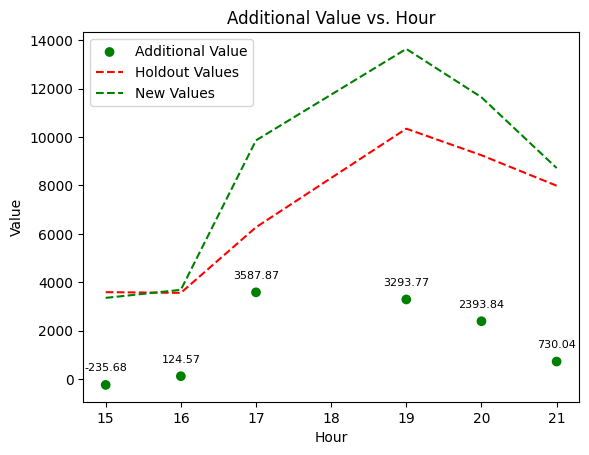

In [432]:
import matplotlib.pyplot as plt

x_values = []
y_values = []
holdout_values = []
new_values = []
colors = []

# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, New Value gained: {max_avg_predicted}")

    # Get the corresponding holdout value for the best location
    holdout_value = filtered_df_dropped.loc[(filtered_df_dropped['LOCATION_ID'] == previous_location_id) & (filtered_df_dropped['HOUR'] == hour), 'Holdout'].values[0]

    print(f"Holdout Value: {holdout_value}")

    additional_value = max_avg_predicted - holdout_value
    print(f"Additional Value: {additional_value}")

    # Append the hour and additional value to the x and y value lists
    x_values.append(hour)
    y_values.append(additional_value)

    # Append the holdout value and new value to the respective lists
    holdout_values.append(holdout_value)
    new_values.append(max_avg_predicted)

    # Check if the location has changed and assign colors accordingly
    if best_location_id == 5176:
        colors.append('red')
    else:
        colors.append('green')

    # Display the numerical value as annotation
    plt.annotate(f'{additional_value:.2f}', (hour, additional_value), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=8)

# Plot the values
plt.scatter(x_values, y_values, c=colors, label='Additional Value')
plt.plot(x_values, holdout_values, color='red', linestyle='--', label='Holdout Values')
plt.plot(x_values, new_values, color='green', linestyle='--', label='New Values')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Additional Value vs. Hour')
plt.legend()
plt.show()
